In [49]:
from __future__ import division
import matplotlib.pyplot as plt
import scipy.fft as sp 
from scipy.fft import fft, fftfreq, fftshift
from math import pi as PI
import math
import cmath
import numpy as np
from scipy import signal
import random as rand
from scipy.fftpack import fft, ifft
import scipy.optimize as opt
import scipy


class FuncParams:
    def __init__(self, from_, to, ampl, omega, shift, N):
        self.From = from_
        self.To = to
        self.Ampl = ampl
        self.Omega = omega
        self.shift = shift
        self.N = N

class Function :
    x = []
    y = []
    
    def __init__(self, FuncParams):
      
       self.From = FuncParams.From
       self.To = FuncParams.To
       self.W = FuncParams.Omega
       self.N = FuncParams.N
       self.Shift = FuncParams.shift
       self.Ampl = FuncParams.Ampl

    def reset_x(self):
       # self.x.clear()
         self.x = np.linspace(self.From, self.To, self.N)

    def calc(self, func, *args, **func_args):
        self.reset_x()
        #for key, val in func_args.items():
         #   print(key, val)
        
        self.y = self.Ampl*func(self.W*(self.x+self.Shift), *args, **func_args)
    def plot(self, title=" "):
        fig = plt.figure()
        subplot = fig.add_subplot(111)
        
        subplot.plot(self.x, self.y, 'b', marker='.', label = title)
        subplot.legend()
        fig.show()

    def normalize(self, value):
        len_ = len(self.y)
        for i in range (0, len_):
            self.y[i] = self.y[i]/value

    def noize(self, intensity, level):
        if intensity >=0:
            increment = 1/intensity
            len_ = len(self.y)
            x = 0
            for i in range(0, len_):
                x+=increment
                if(x>=1):
                    x=0
                    self.y[i] += rand.uniform(-level, +level)

    def FFT(self):
        fft_lib_res = np.fft.fft(self.y)
        spacing_period = (self.From-self.To)/self.N

        xf = fftfreq(self.N, spacing_period)
        return [fftshift(xf), fftshift(fft_lib_res)]

    def IFFT(self):
        ifft_y = np.fft.ifft(self.y)
        #spacing_period = (self.From-self.To)/self.N

        ifft_x = np.linspace(self.From, self.To, len(ifft_y))
        return [ifft_x, ifft_y]
        
    

  
def get_step_Func(f_From, f_To, f_cut_From, f_cut_To, N_pts):
    #N_pts = get_points_numb(f_From, f_To, df)
    Step_Func = Function((FuncParams(f_From, f_To, 1, 1, 0, N_pts)))
    Step_Func.calc(step, f_cut_From, f_cut_To)
    return Step_Func
    

def normalize(y, val):
    for i in range(0, len(y)):
        y[i] = y[i]/val
    return y 

def get_module(y):
    res = []
    for i in range(len(y)):
        res.append(abs(y[i]))
    return res


def plot_y(y, title, From = 0, To = 0):
    fig = plt.figure()
    fig.suptitle(title)
    sp = fig.add_subplot(111)
    if(From != 0 or To != 0):
        x = np.linspace(From, To, len(y))
        sp.plot(x,y)
    else:
        sp.plot(y)
    fig.show()


def IFFT(x, y, from_, to_):
    ifft_y = np.fft.ifft(y)
    #spacing_period = (self.From-self.To)/self.N
    ifft_x = np.linspace(from_, to_, len(ifft_y))
    return [ifft_x, ifft_y]


def FFT(x, y, from_, to_, N):
    '''fft_lib_res = np.fft.fft(y)
    spacing_period = (from_ - to_ / N)

    xf = fftfreq(N, spacing_period)
    return [fftshift(xf), fftshift(fft_lib_res)]'''
    fft_lib_res = np.fft.fft(y)
    
    spacing_period = (to_ - from_)#(to_ - from_ / N)
    x_fft = []
    for i in range(0, len(fft_lib_res)):
        x_fft.append(i / spacing_period)
       
    return [x_fft, fft_lib_res]


def get_points_numb(t_from, t_to, dt):
    return int((t_to - t_from) / dt)


def get_sample_rate(pts_numb, t_from, t_to):
    return int(pts_numb / (t_to - t_from))


def step(x, *args, **kwargs):
    step_from_, step_to_ = args # откуда до куда будут ненулевые значения
                                               # + область определения функции
    
    samples_num = len(x)
    numb_of_pts_within = 0
    
    for x_ in x:
        if step_from_<=x_<=step_to_:
            numb_of_pts_within+=1 # колво точек попадающих в область ступеньки
    
    step_height = 1#1/numb_of_pts_within
    y = []
    for i in range(0, len(x)):
        if step_from_<=x[i]<=step_to_:
            y.append(step_height)
        else:
            y.append(0)
        
    return y

# Получение неидеального фильтра - От синкуса надо оставить часть точек, а остальное добить нулями
# Пробуем оставить часть точек синкуса, а остальные добить нулями
def cut_filter(Pts_to_keep, y_filt):
    Pts_to_keep_left = []
    Pts_to_keep_right = []
    if(Pts_to_keep%2 == 0):
        Pts_to_keep_aside = int(Pts_to_keep / 2)
        print(Pts_to_keep_aside)
        how_many_zeros = len(y_filt) - Pts_to_keep
        Pts_to_keep_left = y_filt[0 : Pts_to_keep_aside]
        Pts_to_keep_right = y_filt[ len(y_filt) - Pts_to_keep_aside : len(y_filt)]
        res = np.concatenate([Pts_to_keep_left, np.zeros(how_many_zeros)])
        res = np.concatenate([res, Pts_to_keep_right])
        return res

def adjust_filter(y):
    #print('len x = ', len(x))
    #x = change_halves(x, len(x)%2 == 0)
    y = change_halves(y, len(y)%2 == 0)
    return y

def mirror_func(x, y):
    x_ = list(x)
    x_ = np.flip(x)
    x_ = [-i for i in x_]
    x_ = np.concatenate([x_, x])
    
    y_ = list(y)
    y_ = np.flip(y_)
    y_  = np.concatenate([y_, y])
    return [x_, y_]

def change_halves(x, is_even):
    x_ = []
    if(is_even):
        x_ = x[len(x)//2 : ]
        print('x even len half x = ', len(x_))
        x_ = np.concatenate([x_, x[ : len(x)//2]])
    else:
        print('x not even')
        x_ = x[len(x)//2 : ]
        x_ = np.concatenate([x_, x[ : len(x)//2]])
    return x_

def plot(x, y, title):
    fig = plt.figure()
    fig.suptitle(title)
    sp = fig.add_subplot(111)
    sp.plot(x, y)
    fig.show()
    
    
def get_FFT_cut(Func):
    [x_fft, y_fft] = FFT(Func.x, Func.y, Func.From, Func.To, Func.N)
    x_fft_cut = x_fft[0 : len(x_fft)//2]
    y_fft_cut = y_fft[0: len(y_fft)//2]
    return [x_fft_cut, y_fft_cut]


def get_fourier_of_filtered_signal(src_spectrum, step):
    y_res = []
    if(len(src_spectrum) == len(step)):
        for i in range(len(src_spectrum)):
            y_res.append(src_spectrum[i] * step[i])
    return y_res
    
    
def plot_func_and_FFT(x, y, title, freq_limits):
    To = x[len(x)-1]
    From = x[0]
    fig = plt.figure()
    fig.suptitle(title)
    sp = fig.add_subplot(121)
    sp.plot(x, y, label = 'src func')
    sp.legend()
    
    [x_fft, y_fft] = FFT(x, y, From, To, len(x))
    sp = fig.add_subplot(122)
    sp.set_xlim(freq_limits)
    sp.plot(x_fft, abs(y_fft), label = 'Fourier')
    sp.legend()
    
    fig.show()
    return fig
    
    
def plot_pefrect_low_pass_filtered(Src_Func, f_cut, func_title, freq_limits):
    [x_fft_cut, y_fft_cut] = get_FFT_cut(Src_Func)
    plot_func_and_FFT(Src_Func.x, Src_Func.y, 'Src func ' + str(func_title), freq_limits)

    Step_Func = get_step_Func(0, x_fft_cut[len(x_fft_cut)-1], 0, f_cut, len(x_fft_cut)) # 5 == F_Nykvist / 2
    plot_func_and_FFT(Step_Func.x, Step_Func.y, 'Step', freq_limits)


    [x_ifft_step, y_ifft_step] = IFFT(Step_Func.x, Step_Func.y, 0, 1)
    y_ifft_step_adj = adjust_filter(y_ifft_step)
    plot(x_ifft_step, y_ifft_step_adj, 'Sincus')

    y_fourier_filtered = get_fourier_of_filtered_signal(y_fft_cut, Step_Func.y)


    [x_filtered, y_filtered] = IFFT(x_fft_cut, y_fourier_filtered, 0, 1)
    x = np.linspace(Src_Func.From, Src_Func.To, len(y_filtered))
    plot_func_and_FFT(x, y_filtered, 'Filtered signal (Perfect Filter) ' + str(func_title), freq_limits)
    
def plot_imperfect_low_pass_filtered(Src_Func, f_cut, Pts_to_keep, func_title):
    [x_fft_cut, y_fft_cut] = get_FFT_cut(Src_Func)
    plot_func_and_FFT(Src_Func.x, Src_Func.y, 'Src func ' + str(func_title))

    
    Step_Func = get_step_Func(0, x_fft_cut[len(x_fft_cut)-1], 0, f_cut, len(x_fft_cut)) # 5 == F_Nykvist / 2
    plot_func_and_FFT(Step_Func.x, Step_Func.y, 'Step')


    [x_ifft_step, y_ifft_step] = IFFT(Step_Func.x, Step_Func.y, 0, 1)

    y_ifft_step_cut = cut_filter(Pts_to_keep, y_ifft_step) # Оставили только 40 коэффициентов синкуса
    plot_y(y_ifft_step_cut, 'cut filter coeff-s', 0,1)

    imperfect_step = np.fft.fft(y_ifft_step_cut)
    plot(Step_Func.x, imperfect_step, 'Imperfect step')

    y_fourier_filtered = []
    if (len(y_fft_cut) == len(imperfect_step)):
        y_fourier_filtered = get_fourier_of_filtered_signal(y_fft_cut, imperfect_step)

    [x_filtered, y_filtered] = IFFT(x_fft_cut, y_fourier_filtered, 0, 1)
    x = np.linspace(sin_Func.From, sin_Func.To, len(y_filtered))
    plot_func_and_FFT(x, y_filtered, 'Filtered signal (Imperfect Filter) ' + str(func_title))
    
    
def plot_imperfect_high_pass_filtered(Src_Func, f_cut, Pts_to_keep, func_title):
    [x_fft_cut, y_fft_cut] = get_FFT_cut(Src_Func)
    plot_func_and_FFT(Src_Func.x, Src_Func.y, 'Src func ' + str(func_title))

    
    Step_Func = get_step_Func(0, x_fft_cut[len(x_fft_cut)-1], f_cut,x_fft_cut[len(x_fft_cut)-1], len(x_fft_cut)) # 5 == F_Nykvist / 2
    plot_func_and_FFT(Step_Func.x, Step_Func.y, 'Step')


    [x_ifft_step, y_ifft_step] = IFFT(Step_Func.x, Step_Func.y, 0, 1)

    y_ifft_step_cut = cut_filter(Pts_to_keep, y_ifft_step) # Оставили только 40 коэффициентов синкуса
    #plot_y(y_ifft_step_cut, 'cut filter coeff-s', 0,1)

    imperfect_step = np.fft.fft(y_ifft_step_cut)
    plot(Step_Func.x, imperfect_step, 'Imperfect step')

    y_fourier_filtered = []
    if (len(y_fft_cut) == len(imperfect_step)):
        y_fourier_filtered = get_fourier_of_filtered_signal(y_fft_cut, imperfect_step)

    [x_filtered, y_filtered] = IFFT(x_fft_cut, y_fourier_filtered, 0, 1)
    x = np.linspace(sin_Func.From, sin_Func.To, len(y_filtered))
    plot_func_and_FFT(x, y_filtered, 'Filtered signal (Imperfect Filter) ' + str(func_title))
    
    
def plot_pefrect_high_pass_filtered(Src_Func, f_cut, func_title):
    [x_fft_cut, y_fft_cut] = get_FFT_cut(Src_Func)
    plot_func_and_FFT(Src_Func.x, Src_Func.y, 'Src func ' + str(func_title))

    Step_Func = get_step_Func(0, x_fft_cut[len(x_fft_cut)-1], f_cut, x_fft_cut[len(x_fft_cut)-1], len(x_fft_cut)) # 5 == F_Nykvist / 2
    plot_func_and_FFT(Step_Func.x, Step_Func.y, 'Step')


    [x_ifft_step, y_ifft_step] = IFFT(Step_Func.x, Step_Func.y, 0, 1)
    y_ifft_step_adj = adjust_filter(y_ifft_step)
    #plot(x_ifft_step, y_ifft_step_adj, 'Sincus (IFFT Step)')

    y_fourier_filtered = get_fourier_of_filtered_signal(y_fft_cut, Step_Func.y)


    [x_filtered, y_filtered] = IFFT(x_fft_cut, y_fourier_filtered, 0, 1)
    x = np.linspace(Src_Func.From, Src_Func.To, len(y_filtered))
    plot_func_and_FFT(x, y_filtered, 'Filtered signal (Perfect Filter) ' + str(func_title))
    
    

    
    

    






<ipython-input-4-6bf0f9f58eeb>:253: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-4-6bf0f9f58eeb>:253: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-4-6bf0f9f58eeb>:253: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


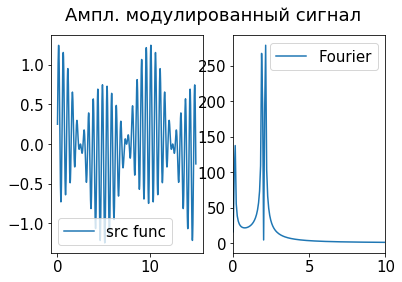

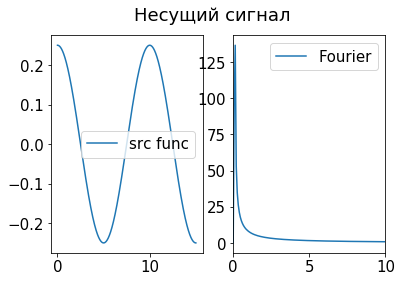

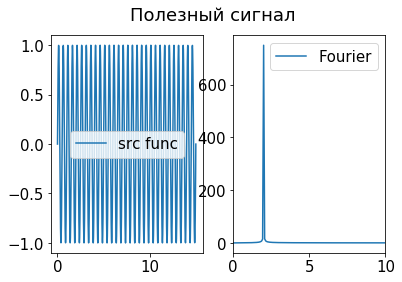

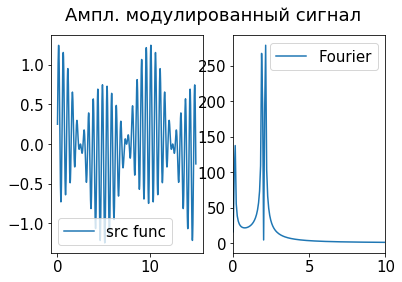

In [19]:
t_from = 0
t_to = 15
dt = 0.01
N = get_points_numb(t_from, t_to, dt)

f_c = 0.1 # Частота несущего сигнала
w_c = 2 * np.pi * f_c
U_c = 0.25 # Carrier Amplitude
modulation_coeff = 0.7 # Coefficient of amplitude modulation

CarrierFunc = Function(FuncParams(t_from, t_to, U_c, 1, 0, N))
CarrierFunc.reset_x()
CarrierFunc.y = U_c * np.cos(w_c * CarrierFunc.x)
#CarrierFunc.plot()
plot_func_and_FFT(CarrierFunc.x, CarrierFunc.y, 'Несущий сигнал', [0, 10])


SrcFunc = Function(FuncParams(t_from, t_to, 1, 1, 0, N))
SrcFunc.reset_x()
f = 2
SrcFunc.y = np.sin(2 * np.pi * f * SrcFunc.x)
plot_func_and_FFT(SrcFunc.x, SrcFunc.y, 'Полезный сигнал', [0, 10])


SrcFuncMax = max(abs(SrcFunc.y))


ModulatedSignal_y = []
signal_length = len(SrcFunc.y)

for i in range(0, signal_length):
    '''ModulatedSignal_y.append( 
        CarrierFunc.y[i] * ( 1 + modulation_coeff * ((SrcFunc.y[i]) / SrcFuncMax))
    )'''
    ModulatedSignal_y.append((U_c + SrcFunc.y[i]) * (CarrierFunc.y[i]/U_c))


ModulatedSignal_x = np.linspace(t_from, t_to, len(ModulatedSignal_y))
ModulatedSignalFunc = Function(FuncParams(t_from, t_to, 1, 1, 0, N))
ModulatedSignalFunc.x = ModulatedSignal_x
ModulatedSignalFunc.y = ModulatedSignal_y

plot_func_and_FFT(ModulatedSignalFunc.x, ModulatedSignalFunc.y, 'Ампл. модулированный сигнал', [0, 10])
                    


(array([0.]), array([0.]), {'grad': array([1.]), 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 6, 'nit': 2, 'warnflag': 0})


<ipython-input-4-6bf0f9f58eeb>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


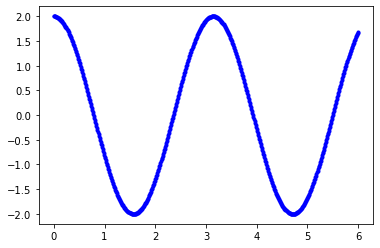

In [6]:
def Uc(t):
    Uc = 2
    w_c = 2
    return Uc * np.cos(w_c * t)

def Signal(t):
    return np.sin(t)



t_from = 0
t_to = 6
dt = 0.01
N = get_points_numb(t_from, t_to, dt)

def get_y(src_arr, func):
    res = []
    for i in src_arr:
        res.append(func(i))
    return res

t = np.linspace(t_from, t_to, N)
y  = get_y(t, Uc)

CarrierFunc = Function(FuncParams(t_from, t_to, 1, 1, 0, N))
CarrierFunc.x = t
CarrierFunc.y = y

CarrierFunc.plot()

max_x = opt.fmin_l_bfgs_b(lambda x: abs(Signal(x)), 1.0, bounds=[(t_from,t_to)],approx_grad=True)
print(max_x)

<ipython-input-49-74d292df89c7>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-49-74d292df89c7>:254: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-49-74d292df89c7>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-49-74d292df89c7>:254: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-49-74d292df89c7>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-49-74d292df89c7>:254: UserWarning: Matplotl

x even len half x =  750


<ipython-input-49-74d292df89c7>:254: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-49-74d292df89c7>:254: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\users\79137\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-49-74d292df89c7>:221: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\users\79137\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy

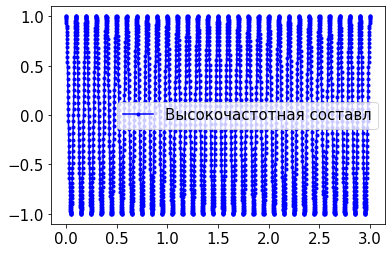

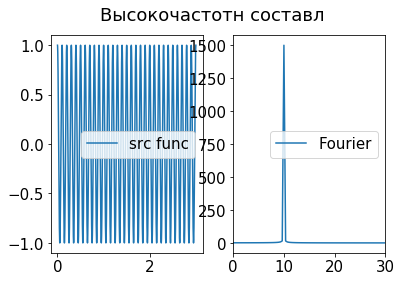

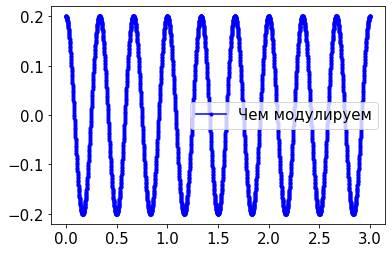

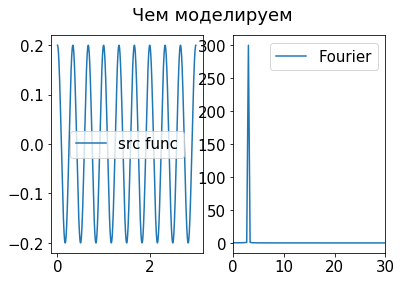

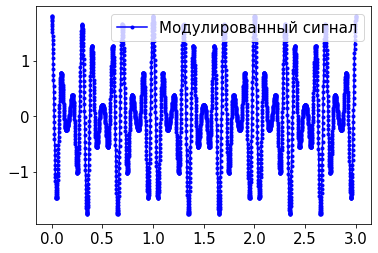

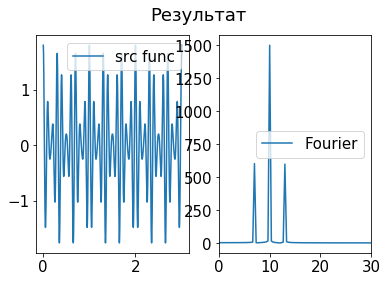

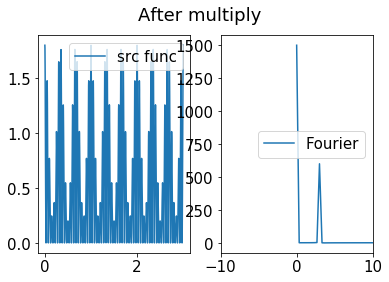

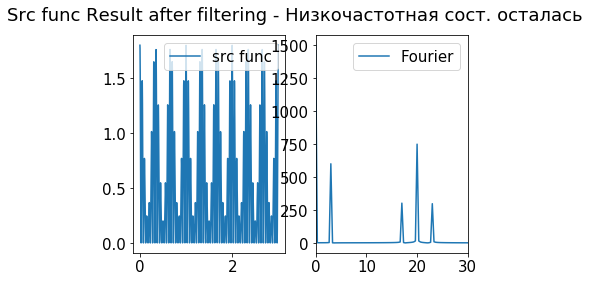

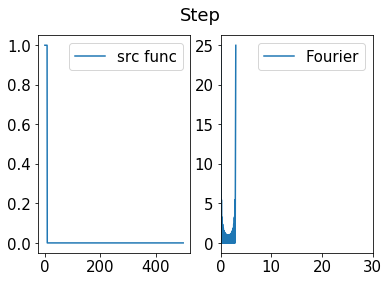

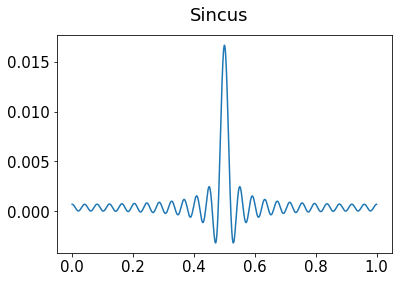

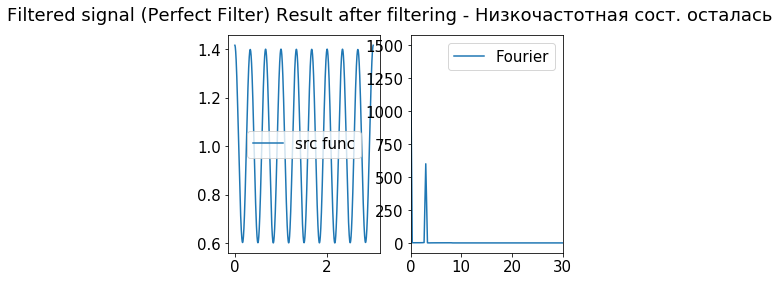

In [77]:
import numpy as np
import matplotlib.pyplot as plt



# Сигнал - информация
A_c = 1 #float(input('Enter carrier amplitude: '))
f_c = 10 #float(input('Enter carrier frquency: '))


# Сигнал которым модулируем
A_m = 0.2 
f_m = 3 
modulation_index = 0.8 

t_from = 0
t_to = 3
dt = 0.001
N = get_points_numb(t_from, t_to, dt)

t = np.linspace(t_from, t_to, N)

carrier = A_c*np.cos(2*np.pi*f_c*t)
modulator = A_m*np.cos(2*np.pi*f_m*t)
product = A_c*(1+modulation_index*np.cos(2*np.pi*f_m*t))*np.cos(2*np.pi*f_c*t)


CarrierFunc = Function(FuncParams(t_from, t_to, 1, 1, 0, N))
CarrierFunc.x = t
CarrierFunc.y = carrier
CarrierFunc.plot('Высокочастотная составл')
plot_func_and_FFT(
    CarrierFunc.x, CarrierFunc.y, 'Высокочастотн составл', [0, 30])

ModulatorFunc = Function(FuncParams(t_from, t_to, 1, 1, 0, N))
ModulatorFunc.x = t
ModulatorFunc.y = modulator
ModulatorFunc.plot('Чем модулируем')
plot_func_and_FFT(
    ModulatorFunc.x, ModulatorFunc.y, 'Чем моделируем', [0, 30])

ResultFunc = Function(FuncParams(t_from, t_to, 1, 1, 0, N))
ResultFunc.x = t
ResultFunc.y = product
ResultFunc.plot('Модулированный сигнал')
plot_func_and_FFT(
    ResultFunc.x, ResultFunc.y, 'Результат', [0, 30])

# Далее - надо умножить на опорный сигнал с W_reference
W_r = 2 * np.pi * f_c
reference_sig = np.cos(W_r * t)
ReferenceSignal = Function(FuncParams(t_from, t_to, 1, 1, 0, N))
ReferenceSignal.x = t

res = []
for i in range (len(reference_sig)):
    res.append(reference_sig[i] * ResultFunc.y[i])
ReferenceSignal.y = res

plot_func_and_FFT(
    ReferenceSignal.x, ReferenceSignal.y, 'After multiply', [-10, 10])

plot_pefrect_low_pass_filtered(ReferenceSignal, 8, 'Result after filtering - Низкочастотная сост. осталась',
                               [0,30])



<ipython-input-49-74d292df89c7>:254: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-49-74d292df89c7>:254: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-49-74d292df89c7>:254: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-49-74d292df89c7>:254: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-49-74d292df89c7>:254: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-49-74d292df89c7>:254: UserWarning: Matpl

x even len half x =  250


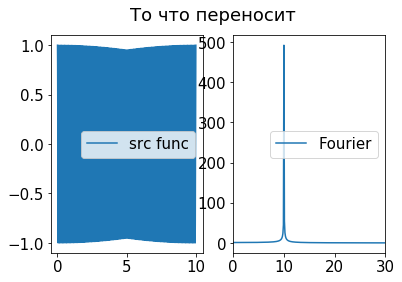

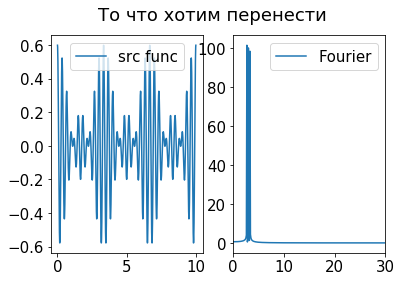

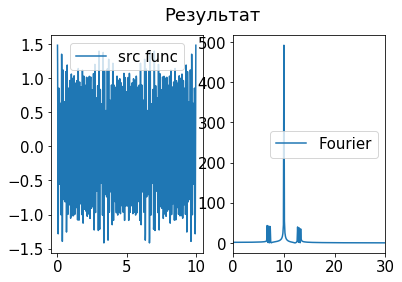

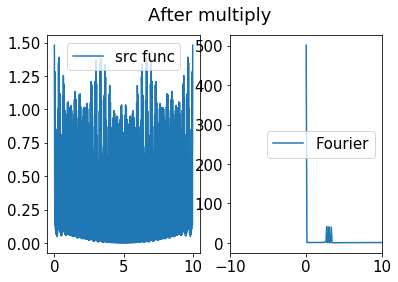

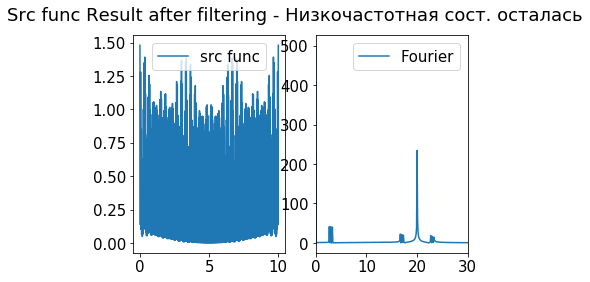

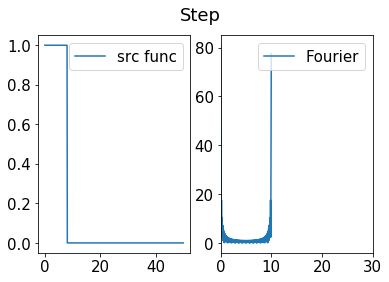

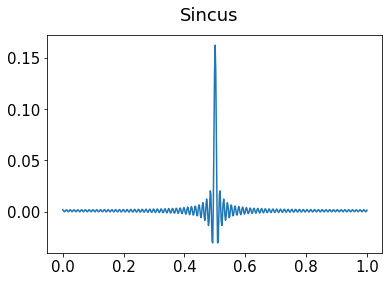

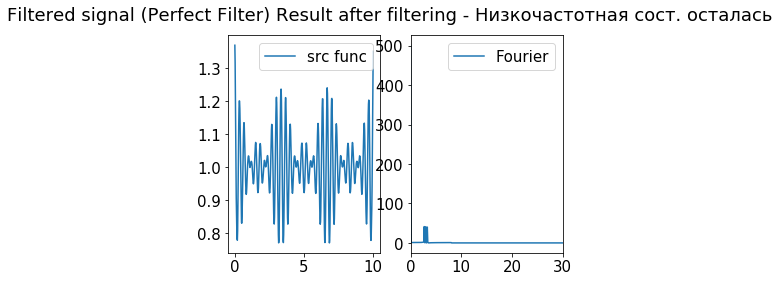

In [93]:
# Сигнал - информация
A_c = 1 #float(input('Enter carrier amplitude: '))
f_c = 10 #float(input('Enter carrier frquency: '))


# Сигнал которым модулируем
A_m = 0.2 
f_m = 3 
modulation_index = 0.8 

t_from = 0
t_to = 10
dt = 0.01
N = get_points_numb(t_from, t_to, dt)

t = np.linspace(t_from, t_to, N)

def Carrier(t):
    return A_c * np.cos(2 * np.pi * f_c * t) # высокочастотная сост

def Modulator(t):
    f1 = f_m
    f2 = f_m - 0.3
    f3 = f_m + 0.3
    return A_m*np.cos(2*np.pi*f1*t) + A_m*np.cos(2*np.pi*f2*t) + A_m*np.cos(2*np.pi*f3*t)

carrier = []
modulator = []
product = []
for i in range (len(t)):
    car_val = Carrier(t[i])
    mod_val = Modulator(t[i])
    carrier = np.append(carrier, (car_val))
    modulator = np.append(modulator, (mod_val))
    product = product = np.append(product, (car_val * (1 + modulation_index * mod_val)))
    
#carrier = A_c*np.cos(2*np.pi*f_c*t)
#modulator = A_m*np.cos(2*np.pi*f_m*t)
#product = A_c*(1+modulation_index*np.cos(2*np.pi*f_m*t))*np.cos(2*np.pi*f_c*t)


CarrierFunc = Function(FuncParams(t_from, t_to, 1, 1, 0, N))
CarrierFunc.x = t
CarrierFunc.y = carrier
#CarrierFunc.plot('Высокочастотная составл')
plot_func_and_FFT(
    CarrierFunc.x, CarrierFunc.y, 'То что переносит', [0, 30])

ModulatorFunc = Function(FuncParams(t_from, t_to, 1, 1, 0, N))
ModulatorFunc.x = t
ModulatorFunc.y = modulator
#ModulatorFunc.plot('То, что хотим перенести')
plot_func_and_FFT(
    ModulatorFunc.x, ModulatorFunc.y, 'То что хотим перенести', [0, 30])

ResultFunc = Function(FuncParams(t_from, t_to, 1, 1, 0, N))
ResultFunc.x = t
ResultFunc.y = product
#ResultFunc.plot('Модулированный сигнал')
plot_func_and_FFT(
    ResultFunc.x, ResultFunc.y, 'Результат', [0, 30])

# Далее - надо умножить на опорный сигнал с W_reference
W_r = 2 * np.pi * f_c
reference_sig = np.cos(W_r * t)
ReferenceSignal = Function(FuncParams(t_from, t_to, 1, 1, 0, N))
ReferenceSignal.x = t

res = []
for i in range (len(reference_sig)):
    res.append(reference_sig[i] * ResultFunc.y[i])
ReferenceSignal.y = res

plot_func_and_FFT(
    ReferenceSignal.x, ReferenceSignal.y, 'After multiply', [-10, 10])

plot_pefrect_low_pass_filtered(ReferenceSignal, 8, 'Result after filtering - Низкочастотная сост. осталась',
                               [0,30])
